In [ ]:
import numpy as np
from trigger_study.wk9.preliminary.OptimumFilter import *
from trace_IO import *
import matplotlib.pyplot as plt
from scipy.stats import describe
import glob

sampling_frequency = 3906250  # Hz
noise_psd = np.load("../../../templates/noise_psd_from_MMC.npy")
sum_psd = 9*noise_psd
template = np.load("sum_qp_template_1800.npy")
sum_of = OptimumFilter(template, sum_psd, sampling_frequency)


In [11]:
quantized_trace = load_traces_from_zstd("/ceph/dwong/mmc_noise_quantized.zst", n_traces=100)
not_quantized_trace = load_traces_from_zstd("/ceph/dwong/mmc_noise_not_quantized.zst", n_traces=100)


In [2]:
# Define the sampling frequency for your data
sampling_frequency = 3906250  # Hz

channel_traces_directory = "individual_vac_1800/"


channel_trace_files = glob.glob(os.path.join(channel_traces_directory, "channel_*_normalized_trace.npy"))

channel_optimum_filters = {}

print("\n--- Creating Channel-wise Optimum Filters ---")
for file_path in sorted(channel_trace_files): # Sort for consistent order
    # Extract the channel number from the filename (e.g., 'channel_45_normalized_trace.npy' -> 45)
    file_name = os.path.basename(file_path)
    channel_number = int(file_name.split('_')[1])

    # Load the normalized trace for the current channel to use as its template
    channel_template = np.load(file_path) # Use your actual trace loading function here
    of = OptimumFilter(channel_template, noise_psd, sampling_frequency)

    # Store the created optimum filter in the dictionary
    channel_optimum_filters[channel_number] = of




--- Creating Channel-wise Optimum Filters ---


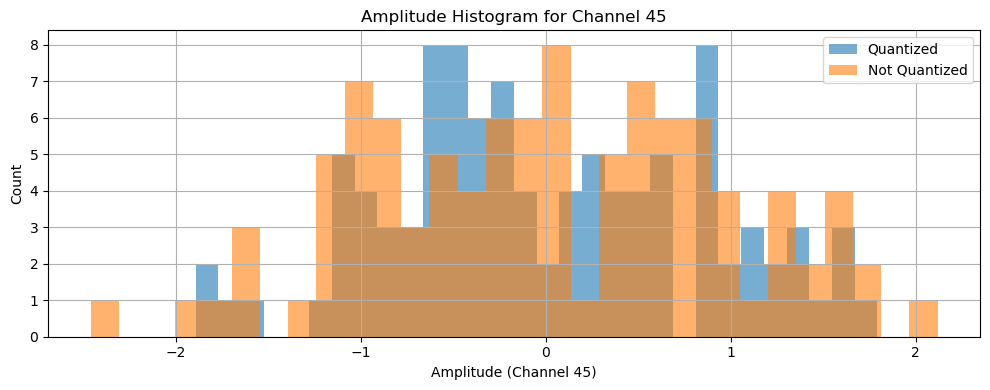

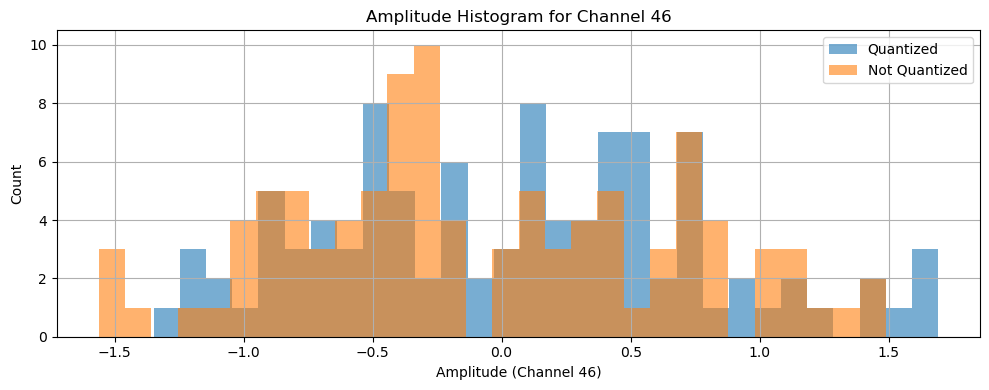

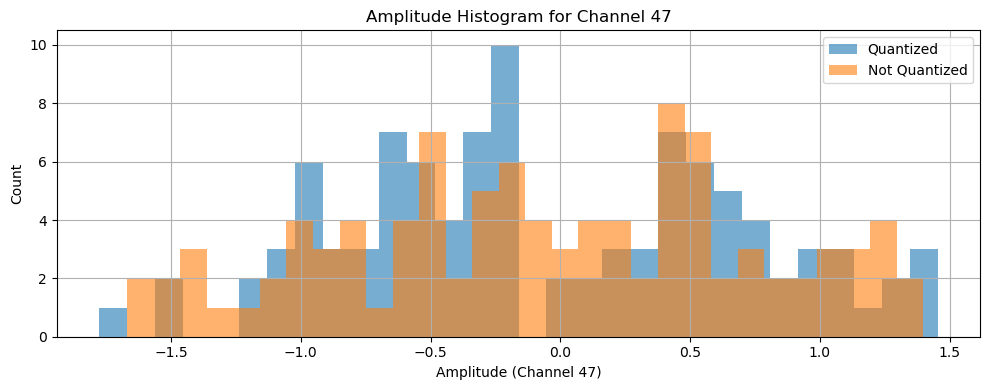

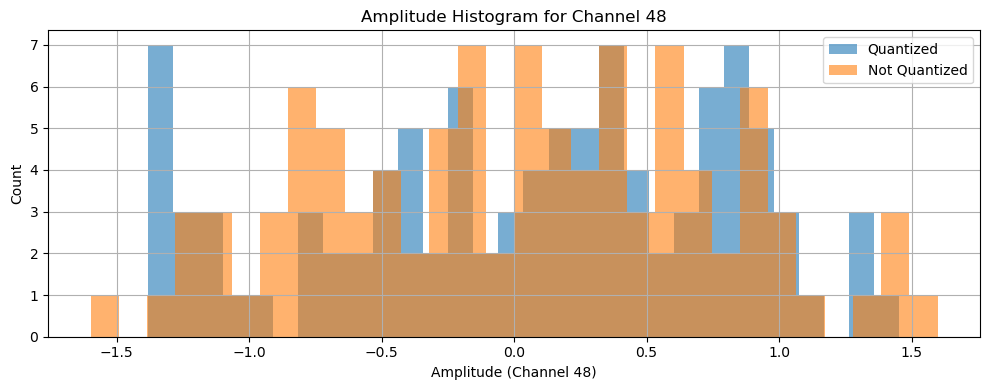

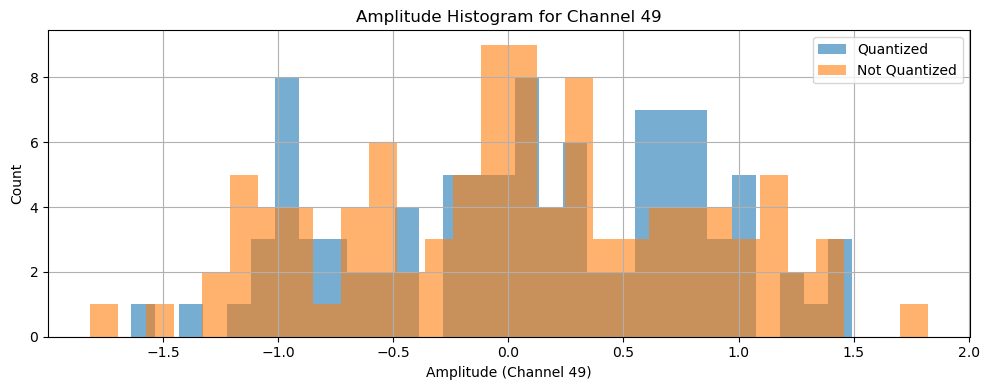

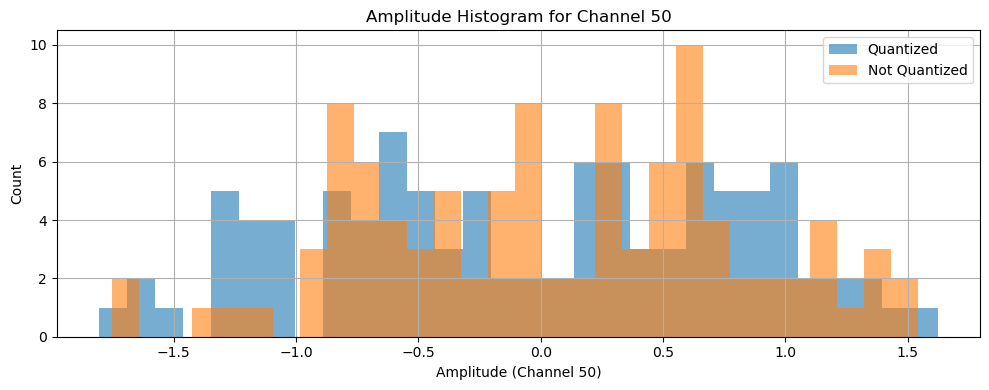

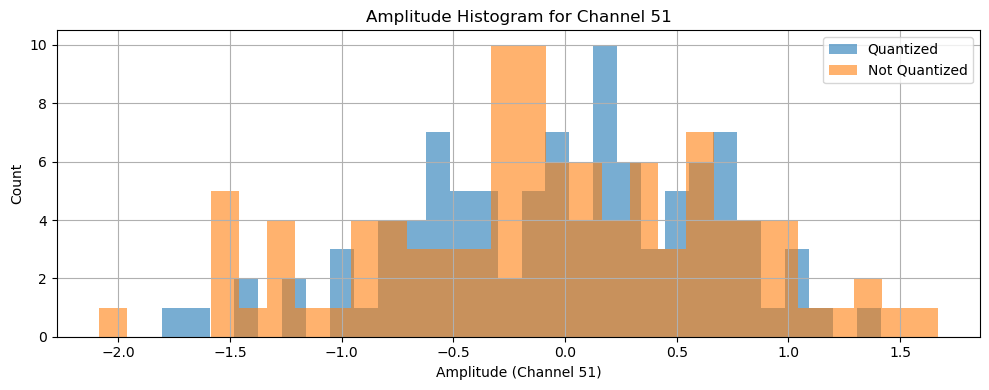

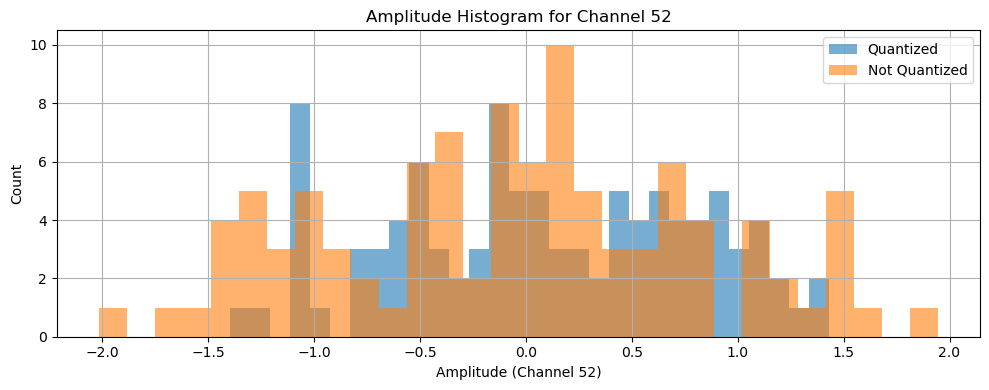

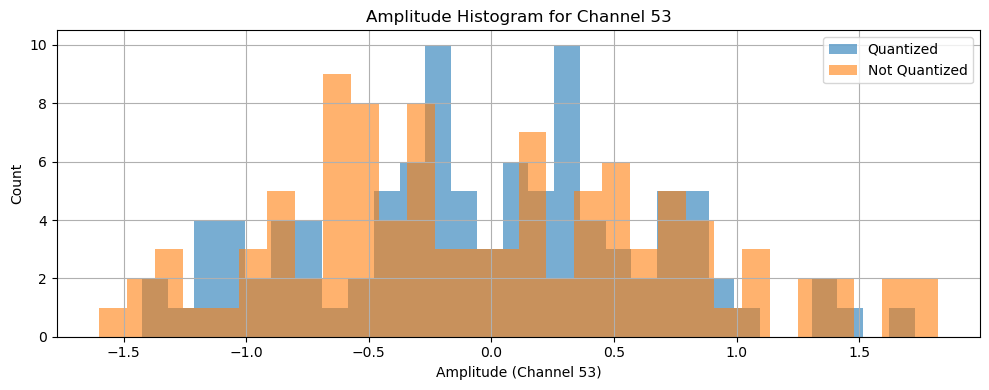

--- Quantized Amplitudes (Channel 45) ---
Mean      : 0.0116
Std Dev   : 0.8440
Min       : -1.8922
Max       : 1.7925

--- Quantized Amplitudes (Channel 46) ---
Mean      : 0.0584
Std Dev   : 0.7196
Min       : -1.3480
Max       : 1.6911

--- Quantized Amplitudes (Channel 47) ---
Mean      : -0.0465
Std Dev   : 0.7514
Min       : -1.7775
Max       : 1.4557

--- Quantized Amplitudes (Channel 48) ---
Mean      : 0.0507
Std Dev   : 0.7595
Min       : -1.3807
Max       : 1.4513

--- Quantized Amplitudes (Channel 49) ---
Mean      : 0.0939
Std Dev   : 0.7367
Min       : -1.6409
Max       : 1.4916

--- Quantized Amplitudes (Channel 50) ---
Mean      : -0.0404
Std Dev   : 0.8430
Min       : -1.8054
Max       : 1.6236

--- Quantized Amplitudes (Channel 51) ---
Mean      : -0.0200
Std Dev   : 0.6612
Min       : -1.8041
Max       : 1.4146

--- Quantized Amplitudes (Channel 52) ---
Mean      : 0.0830
Std Dev   : 0.7112
Min       : -1.3996
Max       : 1.4311

--- Quantized Amplitudes (Channel 53)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe

# This is assumed to be a dictionary mapping channel number to its OptimumFilter instance
# Example: channel_optimum_filters = {45: OF45, 46: OF46, ..., 53: OF53}

def process_trace_set_channelwise(trace_set, channel_optimum_filters):
    """
    Processes a 3D trace set (n_traces, n_channels, n_samples)
    Returns:
        - dict of amplitudes per channel
        - dict of chi-squareds per channel
    """
    n_channels = 9
    base_channel = 45
    amplitudes = {ch: [] for ch in range(base_channel, base_channel + n_channels)}
    chisqs = {ch: [] for ch in range(base_channel, base_channel + n_channels)}

    for trace in trace_set:
        for ch in range(base_channel, base_channel + n_channels):
            fitted_ampl, fitted_chisq = channel_optimum_filters[ch].fit(trace[ch])
            amplitudes[ch].append(fitted_ampl)
            chisqs[ch].append(fitted_chisq)

    # Convert to numpy arrays
    amplitudes = {ch: np.array(ampl) for ch, ampl in amplitudes.items()}
    chisqs = {ch: np.array(chisq) for ch, chisq in chisqs.items()}
    return amplitudes, chisqs

# Process datasets
ampl_q, chisq_q = process_trace_set_channelwise(quantized_trace, channel_optimum_filters)
ampl_nq, chisq_nq = process_trace_set_channelwise(not_quantized_trace, channel_optimum_filters)

# Plot histograms for each channel
for ch in range(45, 54):
    plt.figure(figsize=(10, 4))
    plt.hist(ampl_q[ch], bins=30, alpha=0.6, label='Quantized')
    plt.hist(ampl_nq[ch], bins=30, alpha=0.6, label='Not Quantized')
    plt.xlabel(f"Amplitude (Channel {ch})")
    plt.ylabel("Count")
    plt.title(f"Amplitude Histogram for Channel {ch}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print statistics per channel
def print_stats(name, data_by_channel):
    for ch in sorted(data_by_channel.keys()):
        stats = describe(data_by_channel[ch])
        print(f"--- {name} (Channel {ch}) ---")
        print(f"Mean      : {stats.mean:.4f}")
        print(f"Std Dev   : {np.sqrt(stats.variance):.4f}")
        print(f"Min       : {stats.minmax[0]:.4f}")
        print(f"Max       : {stats.minmax[1]:.4f}")
        print()

print_stats("Quantized Amplitudes", ampl_q)
print_stats("Not Quantized Amplitudes", ampl_nq)


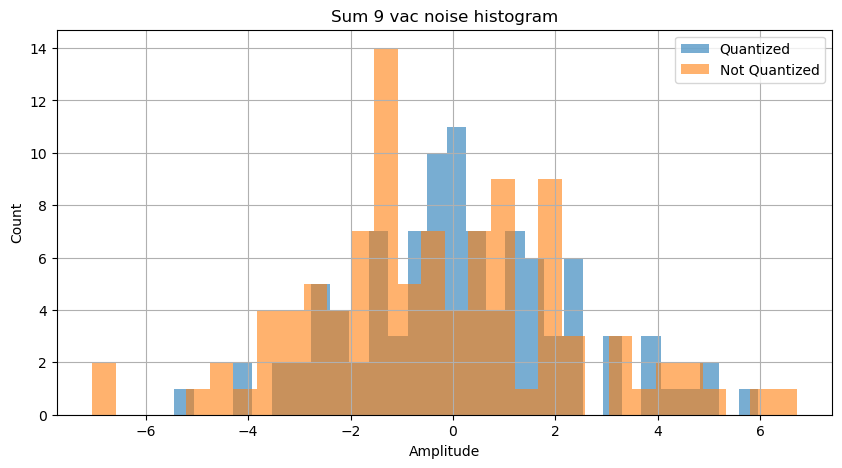

--- Quantized Amplitudes ---
Mean      : 0.1867
Std Dev   : 2.1476
Min       : -5.4423
Max       : 5.9658

--- Not Quantized Amplitudes ---
Mean      : -0.3393
Std Dev   : 2.5799
Min       : -7.0456
Max       : 6.7193



In [21]:
def process_trace_set(trace_set):
    amplitudes = []
    chisqs = []
    
    for i in range(trace_set.shape[0]):
        summed_trace = np.sum(trace_set[i, 45:, :], axis=0)  # Sum channels 45 to 53
        ampl, chisq = sum_of.fit(summed_trace)
        amplitudes.append(ampl)
        chisqs.append(chisq)
    
    return np.array(amplitudes), np.array(chisqs)

# Process both datasets
ampl_q, chisq_q = process_trace_set(quantized_trace)
ampl_nq, chisq_nq = process_trace_set(not_quantized_trace)

# Plot histogram of amplitudes
plt.figure(figsize=(10, 5))
plt.hist(ampl_q, bins=30, alpha=0.6, label='Quantized')
plt.hist(ampl_nq, bins=30, alpha=0.6, label='Not Quantized')
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title("Sum 9 vac noise histogram")
plt.legend()
plt.grid(True)
plt.show()

# Print statistics
def print_stats(name, data):
    stats = describe(data)
    print(f"--- {name} ---")
    print(f"Mean      : {stats.mean:.4f}")
    print(f"Std Dev   : {np.sqrt(stats.variance):.4f}")
    print(f"Min       : {stats.minmax[0]:.4f}")
    print(f"Max       : {stats.minmax[1]:.4f}")
    print()

print_stats("Quantized Amplitudes", ampl_q)
print_stats("Not Quantized Amplitudes", ampl_nq)

Processing files: 100%|██████████| 32/32 [1:05:17<00:00, 122.42s/it]  


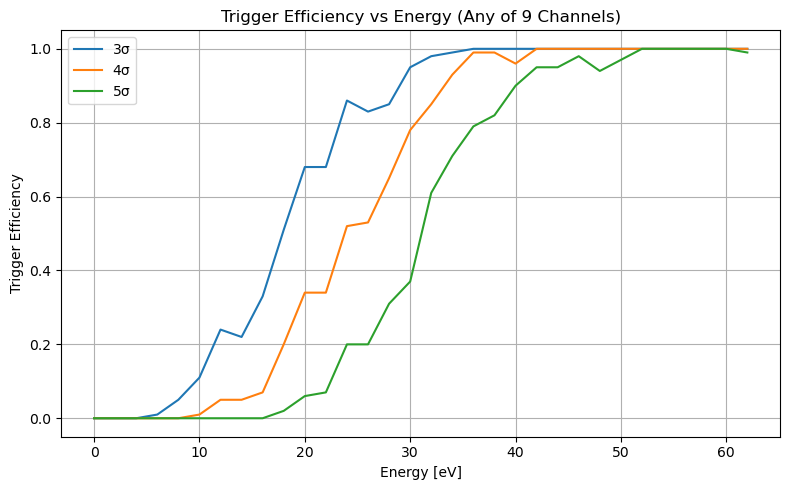

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Define thresholds using vacuum std values from quantized noise
channel_std = {
    45: 0.8440, 46: 0.7196, 47: 0.7514, 48: 0.7595, 49: 0.7367,
    50: 0.8430, 51: 0.6612, 52: 0.7112, 53: 0.6817,
}
thresholds = {
    n: {ch: sigma * n for ch, sigma in channel_std.items()}
    for n in [3, 4, 5]
}

# Path to QP sample files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract energy from filenames
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Store results
efficiency_results = {thr: [0.0] * len(file_paths) for thr in thresholds}

# Worker function to process one file
def process_file(index, energy, path):
    quantized_traces = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    triggered_counts = {thr: 0 for thr in thresholds}

    for trace_set in quantized_traces:
        channel_amplitudes = []
        for ch in range(45, 54):
            amp, _ = channel_optimum_filters[ch].fit(trace_set[ch])
            channel_amplitudes.append((ch, amp))

        for thr_val in thresholds:
            for ch, amp in channel_amplitudes:
                if amp > thresholds[thr_val][ch]:
                    triggered_counts[thr_val] += 1
                    break

    return index, {
        thr_val: triggered_counts[thr_val] / len(quantized_traces)
        for thr_val in thresholds
    }

# Run in parallel with max 10 threads and track progress
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_file, i, e, p) for i, (e, p) in enumerate(zip(energies, file_paths))]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        idx, result = future.result()
        for thr_val in result:
            efficiency_results[thr_val][idx] = result[thr_val]

# Plot efficiency curves
plt.figure(figsize=(8, 5))
for thr_val in sorted(thresholds):
    plt.plot(energies, efficiency_results[thr_val], label=f"{thr_val}σ")
plt.xlabel("Energy [eV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency vs Energy (Any of 9 Channels)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Thresholds
threshold_base = 2.1476
thresholds = [threshold_base * n for n in [3, 4, 5]]

# Path to QP sample files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract and sort energies numerically
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Store efficiency results
efficiency_results = {thr: [] for thr in thresholds}

# Process each energy level
for energy, path in zip(energies, file_paths):
    quantized_trace = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    
    amplitudes = []
    for trace_set in quantized_trace:
        sum_trace = np.sum(trace_set[45:], axis=0)
        amp = sum_of.fit(sum_trace)
        amplitudes.append(amp)
    
    amplitudes = np.array(amplitudes)
    
    for thr in thresholds:
        pass_rate = np.sum(amplitudes > thr) / len(amplitudes)
        efficiency_results[thr].append(pass_rate)

In [16]:
plt.figure(figsize=(8, 5))

# Plot individual channel efficiencies (dashed)
for thr in thresholds:
    plt.plot(
        energies,
        efficiency_results_individual[thr],
        linestyle='--',
        label=f"Individual ≥ {thr:.2f}"
    )

# Plot summed channel efficiency (solid)
for thr in thresholds:
    plt.plot(
        energies,
        efficiency_results[thr],
        linestyle='-',
        label=f"Sum ≥ {thr:.2f}"
    )

plt.xlabel("Energy [eV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency vs Energy (Sum vs Individual)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'efficiency_results_individual' is not defined

<Figure size 800x500 with 0 Axes>

Loading traces: 100%|██████████| 32/32 [01:41<00:00,  3.17s/it]


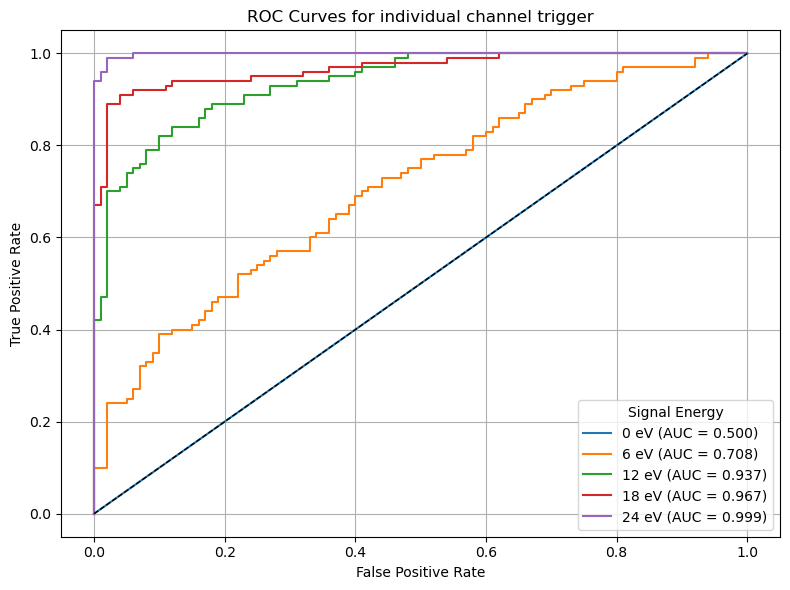

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import re
from tqdm import tqdm

# Channel-specific stds from vacuum noise
channel_std = {
    45: 0.8440, 46: 0.7196, 47: 0.7514, 48: 0.7595, 49: 0.7367,
    50: 0.8430, 51: 0.6612, 52: 0.7112, 53: 0.6817,
}

# Target energies
energies_to_use = [0, 6, 12, 18, 24]

# Load all relevant files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract energy from filenames
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Load amplitudes from all selected energies
energy_to_scores = {}

for energy, path in tqdm(zip(energies, file_paths), total=len(file_paths), desc="Loading traces"):
    if energy not in energies_to_use:
        continue

    traces = load_traces_from_zstd(str(path), n_traces=100)  # (100, 54, 32768)
    max_amplitudes = []

    for trace_set in traces:
        channel_amps = []
        for ch in range(45, 54):
            amp, _ = channel_optimum_filters[ch].fit(trace_set[ch])
            channel_amps.append(amp)
        max_amplitudes.append(max(channel_amps))  # use max channel amplitude as score

    energy_to_scores[energy] = np.array(max_amplitudes)

# Compute and plot ROC curve per signal energy (vs 0 eV)
plt.figure(figsize=(8, 6))
background_scores = energy_to_scores[0]

for signal_energy in [0, 6, 12, 18, 24]:
    signal_scores = energy_to_scores[signal_energy]

    scores = np.concatenate([background_scores, signal_scores])
    labels = np.concatenate([
        np.zeros(len(background_scores)),  # 0 = noise
        np.ones(len(signal_scores))       # 1 = signal
    ])

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for individual channel trigger")
plt.grid(True)
plt.legend(title="Signal Energy")
plt.tight_layout()
plt.show()
